# Comprehensive PPG Analysis

In this tutorial we will learn how to extract biomarkers from a photoplethysmogram (PPG) signal.

Our objectives are to:

- Detect the standard fiducial points on PPG pulse waves
- Calculate pulse wave biomarkers from the fiducial points
- Saving data in different data format

You can use the sample PPG data by downloading it from the following link: [Sample PPG data](https://zenodo.org/record/8369487/files/Sample_PPG_MAT_125Hz.mat?download=1).


## Setup

Import Python packages:
________________________

- Install the _[pyPPG](https://pyppg.readthedocs.io/)_ toolbox for PPG analysis

In [2]:
!pip install pyPPG==1.0.41

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 774.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 46.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.9 MB/s 

- Import required components from _pyPPG_

In [5]:
from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI

- Import other packages

In [7]:
import numpy as np
import sys
import json
import pandas as pd

Setup input parameters:
_______________________
_The following input parameters are inputs to the `pyPPG.example` module (see the [documentation](https://pyppg.readthedocs.io/en/latest/pyPPG.html#module-pyPPG.example) for further details)._

In [39]:
data_path = "/content/Sample_PPG_MAT_125Hz.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

Load a raw PPG signal:
__________________________

In [40]:
signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)
signal.v = signal.v [0:60*signal.fs] # 20 second long signal to be analysed

Plot the raw PPG signal:

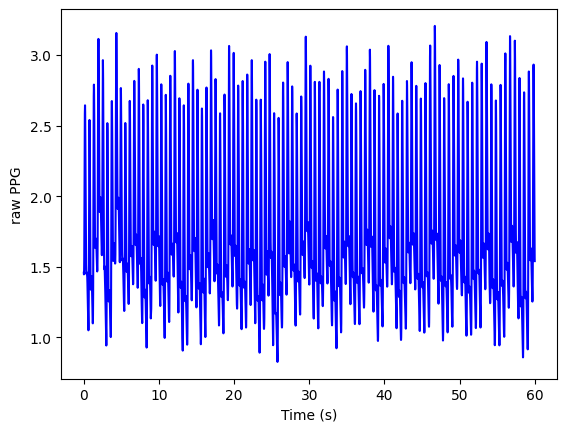

In [41]:
# import plotting package
from matplotlib import pyplot as plt

# setup figure
fig, ax = plt.subplots()

# create time vector
t = np.arange(0, len(signal.v))/signal.fs

# plot raw PPG signal
ax.plot(t, signal.v, color = 'blue')
ax.set(xlabel = 'Time (s)', ylabel = 'raw PPG')

# show plot
plt.show()

## PPG signal processing

Filter the PPG signal and obtain first, second and third derivatives (_vpg_, _apg_, and _jpg_ respectively).

In [42]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=12 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

Plot the derived signals

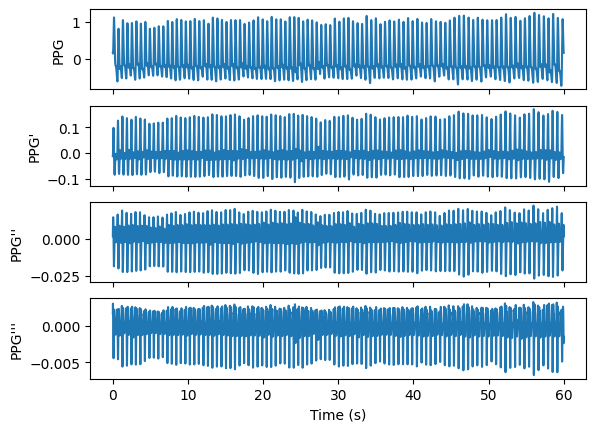

In [43]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()

Store the derived signals in a class

In [44]:
# Initialise the correction for fiducial points
corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Create a PPG class
s = PPG(signal)

Identify fiducial points:
__________________________

Initialise the fiducials package

In [45]:
fpex = FP.FpCollection(s)

Extract fiducial points

In [46]:
fiducials = fpex.get_fiducials(s)

Display the results

In [47]:
print("Fiducial points:\n",fiducials + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)

Fiducial points:
                   on    sp    dn    dp   off     u     v     w     a     b  \
Index of pulse                                                               
0                  0    19    42    47    75    12    28    46     5    17   
1                 75    95   116   128   149    86   103   120    79    92   
2                149   168   194   198   223   159   176   195   153   165   
3                223   243   265   277   298   235   251   269   228   240   
4                298   318   341   346   372   309   326   342   303   315   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
89              6756  6777  6799  6809  6834  6769  6786  6802  6762  6774   
90              6834  6853  6877  6884  6911  6845  6862  6879  6838  6850   
91              6911  6931  6956  6961  6990  6922  6940  6957  6916  6928   
92              6990  7010  7035  7041  7068  7002  7019  7037  6995  7007   
93              7068  7088  7111  7121  7148  

Plot fiducial points
__________________________

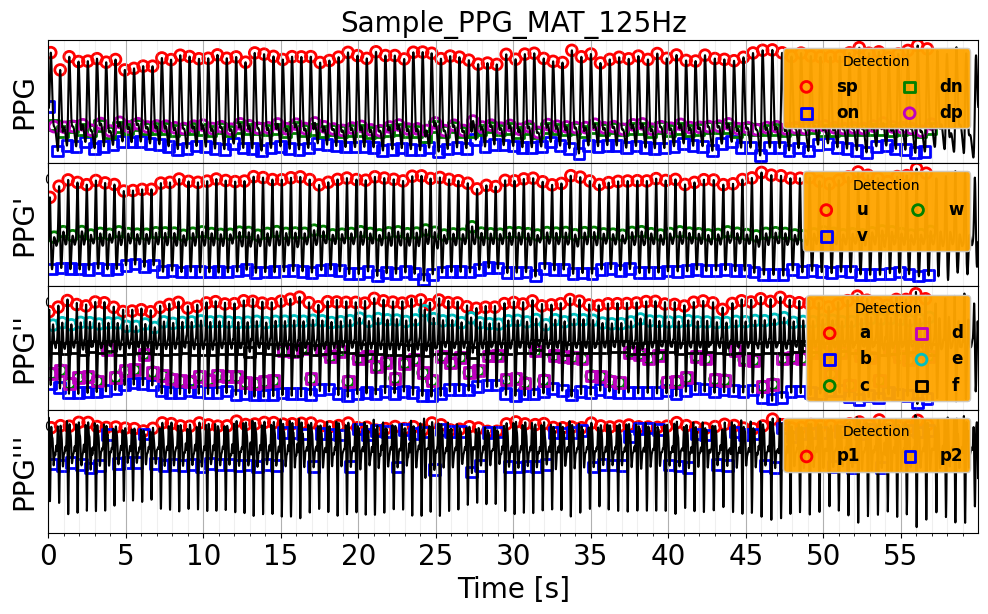

Figure has been saved in the "temp_dir".


In [48]:
# Create a fiducials class
fp = Fiducials(fiducials)

# Plot fiducial points
plot_fiducials(s, fp, savingfolder, legend_fontsize=12)

Calculate PPG SQI:
_________________________

In [49]:
# Get PPG SQI
ppgSQI = round(np.mean(SQI.get_ppgSQI(s.ppg, s.fs, fp.sp)) * 100, 2)
print('Mean PPG SQI: ', ppgSQI, '%')

Mean PPG SQI:  98.7 %


Calculate PPG biomarkers:
_________________________

Initialise the biomarkers package

In [50]:
bmex = BM.BmCollection(s, fp)

Extract biomarkers

In [51]:
bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()
tmp_keys=bm_stats.keys()
print('Statistics of the biomarkers:')
for i in tmp_keys: print(i,'\n',bm_stats[i])

# Create a biomarkers class
bm = Biomarkers(bm_defs, bm_vals, bm_stats)

Statistics of the biomarkers:
ppg_sig 
                     Tpi       Tpp      Tsys      Tdia           Tsp       Tdp  \
Statistics                                                                      
mean           0.608000  0.608086  0.346237  0.192086  1.604301e-01  0.415914   
median         0.608000  0.608000  0.344000  0.192000  1.600000e-01  0.416000   
std            0.014176  0.012824  0.008408  0.016021  5.162724e-03  0.012931   
percentile_25  0.600000  0.600000  0.344000  0.176000  1.600000e-01  0.408000   
percentile_75  0.616000  0.616000  0.352000  0.200000  1.600000e-01  0.424000   
iqr            0.016000  0.016000  0.008000  0.024000  7.105427e-15  0.016000   
skew           0.255118  0.593274  0.090822  0.643892 -2.905171e-01 -0.303387   
kurtosis      -0.508773 -0.184628 -0.441947 -0.053291  2.169001e-01  0.266300   
mad            0.011355  0.009925  0.006946  0.012498  3.418661e-03  0.009916   

                 deltaT     Tsw10         Tsw25         Tsw33  ...  

Save PPG data:
______________

In [52]:
# Save PPG struct, fiducial points, biomarkers
fp_new = Fiducials(fp.get_fp() + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)
save_data(s, fp_new, bm, savingformat, savingfolder)

Results have been saved into the "temp_dir".


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import os

In [94]:



# Create a DataFrame from biomarkers and add heart rate
biomarker_file_path = "/content/temp_dir/Biomarker_vals/Sample_PPG_MAT_125Hz_ppg_sig_btwn_0-15001.csv"
# Load the biomarker values into a DataFrame
biomarkers_df = pd.read_csv(biomarker_file_path)
biomarkers_df['HeartRate'] = 60 / biomarkers_df.Tpp

# Select relevant biomarkers as features
selected_biomarkers = ['Tpi','Tpp','Tsys','Tdia','deltaT']
X = biomarkers_df[selected_biomarkers]
y = biomarkers_df['HeartRate']  # Target variable (ground truth)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=400, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
print(y_pred)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error: {:.2f}".format(mae))
print("R-squared: {:.2f}".format(r2))
# Save the DataFrame with Heart Rate
output_file_path = os.path.join(savingfolder, 'biomarkers_with_hr.csv')
biomarkers_df.to_csv(output_file_path, index=False)

# Download the file
#from google.colab import files
#files.download(output_file_path)


[102.17049241 100.         100.          95.35275049  98.68421053
 100.         100.          96.16032405  98.68421053  98.68421053
  98.68421053  98.68421053  96.35364635  96.16032405 101.35135135
 101.35135135 100.         100.          98.68421053]
Mean Absolute Error: 0.08
R-squared: 0.98
